**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[//]: # (Image References)
[image1]: ./output_images/car_example.png
[image2]: ./output_images/non_car_example.png
[image3]: ./output_images/cars_found.png
[image4]: ./output_images/outputfigure.png
[image5]: ./output_images/HOG_out.png
[image6]: ./output_images/Notcar_HOG_out.png
[image7]: ./output_images/output_bboxes.png
[video1]: ./project_video_output.mp4

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  


## Data Preparation

To train the classifier, I used the labeled data for vehicle and non-vehicle examples provided in the class, which is a combination of the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself. I used the SVM as a classifier, and trained it on my pc. To save computational time, I did not use all of the data but randomly chose 5000 examples out of the not-car examples and 4000 out of the car examples. Below are an example of the car and non-car images provided:

![alt text][image1]

![alt text][image2]

## Feature Extraction

I used a combined feature of hog features, spatial color features and color histogram features. The code for this step is contained under the file lesson_functions.py and in the function extract_features.


### Histogram of Oriented Gradients (HOG)

To compute the HOG of the images, I used the scikit-image library. The code for this step is contained under the file lesson_functions.py and in the function get_hog_features. As for the configuration, I used the following parameters:

orient = 9  # HOG orientations

pix_per_cell = 8 # HOG pixels per cell

cell_per_block = 2 # HOG cells per block

which is provided in the class and yield over 99% of accuracy in the trained SVM. As for the color space, I used the `YCrCb` color space. Here is an example using the `YCrCb` color space and HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)` on the non-car example:
![alt text][image5]
And here is an example of using the `YCrCb` color space and HOG parameters as described on a car example:
![alt text][image6]

I trained a linear SVM using the svm.SVC function in the scikit-learn library.The trained classifier yield an accuracy of 0.9922.

### Sliding Window Search


I decided to restrict my search to the area in the image where a car can be present (400 to 656 along the y-axis). The window size and overlap where the same as those used in the lesson since they worked well for detecting vehicles.
![alt text][image3]
Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:
![alt text][image4]

### Video Implementation

The result of the vehicle detection pipleline is uploaded to this repository.
Here's a [link to my video result](./project_video_output.mp4)


I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  




### Discussion


I noticed that in the video where two cars are very close, it is detected as a single but bigger car. To resolve this issue I would like to detect if the region which is hot in the heatmap has two hot centroids instead of one, signalling the presence of two vehicles. 

---

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.externals import joblib
from lesson_functions import *
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from collections import deque



## Data Loading

In [4]:
# Read in cars and notcars
images = glob.glob('./non-vehicles/*/*.png')
cars = []
notcars = []
noncars_list=random.sample(images, 5000)
for image in noncars_list:
    notcars.append(image)
print("number of non-car examples are:", len(notcars))

images = glob.glob('./vehicles/*/*.png')
cars_list=random.sample(images, 4000)
for image in cars_list:
        cars.append(image)
print("number of car examples are:", len(cars))


number of non-car examples are: 5000
number of car examples are: 4000


## Here is the beginning of the main_step

In [5]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
ystart = 400 # Min and max in y to search in slide_window()
ystop = 656
scale = 1.5
heat_threshold=26
b_boxes_deque = deque(maxlen=30)

load_trained = True
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('car_features length: ', len(car_features))
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('notcar_features length: ', len(notcar_features))
#print("not car features shape", notcar_features.shape)
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print("X shape", X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Feature vector shape:', X_train.shape)
# Use a linear SVC 
if load_trained == True:
    svc, X_scaler = joblib.load('svc-model.pkl')
else:
    svc = LinearSVC()
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    joblib.dump((svc, X_scaler), 'svc-model.pkl')
# Check the training time for the SVC

# Check the score of the SVCX
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print(scaled_X.shape)

C:\MyProgs\Conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


car_features length:  4000
notcar_features length:  5000
X shape (9000, 8460)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
Feature vector shape: (7200, 8460)
Test Accuracy of SVC =  0.9944
(9000, 8460)


## Visualization

1


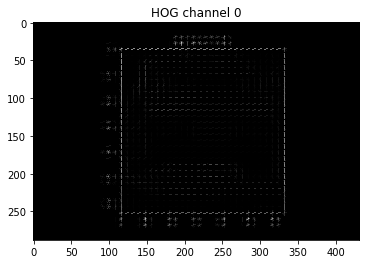

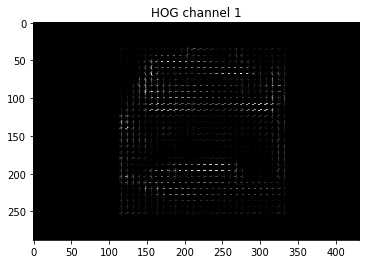

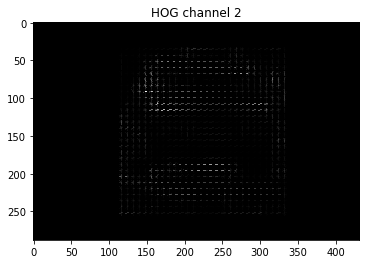

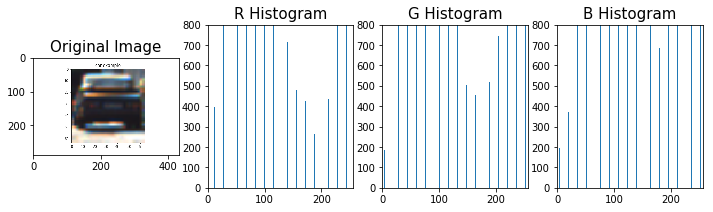

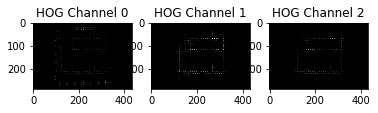

OSError: [Errno 22] Invalid argument: '.\\output_images\non_car_example.png'

In [14]:
print("1")
image_orig = mpimg.imread('.\output_images\car_example.png')
plt.figure()
plt.title("car example")
outfile = "car example.png"
plt.imshow(image_orig)
#plt.savefig(outfile)
imgYcrCb = cv2.cvtColor(image_orig, cv2.COLOR_RGB2YCrCb)
image_list=[]

for channel in range(3):
    features,hog_image = get_hog_features(imgYcrCb[:,:,channel], orient, pix_per_cell, 
                                          cell_per_block, vis=True, feature_vec=True)

    title = 'HOG channel %s' % (channel)
    plt.title(title)
    plt.imshow(hog_image,cmap='gray')
    outfile='Car_HOG_channel %s.png' % (channel)
    image_list.append(hog_image)
    #plt.savefig(outfile)
    plt.show()
    
image_orig = cv2.imread('.\output_images\car_example.png')
image = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
channel1_hist, channel2_hist, channel3_hist, bin_centers = color_hist(image, vis=True)
# Plot the examples
fig = plt.figure(figsize=(12,3));

plt.subplot(141)
plt.imshow(image)
plt.title('Original Image', fontsize=15)
plt.subplot(142)
plt.bar(bin_centers, channel1_hist[0])
plt.xlim(0, 256)
plt.ylim(0, 800)
plt.title('R Histogram', fontsize=15);
plt.subplot(143)
plt.bar(bin_centers, channel2_hist[0])
plt.xlim(0, 256)
plt.ylim(0, 800)
plt.title('G Histogram', fontsize=15);
plt.subplot(144)
plt.bar(bin_centers, channel3_hist[0])
plt.xlim(0, 256)
plt.ylim(0, 800)
plt.title('B Histogram', fontsize=15);
plt.show()
plt.savefig('output_images/color_hist_vis.png', 
            bbox_inches="tight")    
    
    
    
plt.figure()
plt.subplot(131)
plt.title("HOG Channel 0")
plt.imshow(image_list[0], cmap='gray')
plt.subplot(132)
plt.title("HOG Channel 1")
plt.imshow(image_list[1], cmap='gray')
plt.subplot(133)
plt.title("HOG Channel 2")
plt.imshow(image_list[2], cmap='gray')
plt.savefig("HOG_out.png")
plt.show()   
    
    
image_list=[] 
image = mpimg.imread('.\output_images\non_car_example.png')
img = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
plt.figure()
plt.title("non-car example")
outfile = "non-car example.png"
plt.imshow(image)
#plt.savefig(outfile)
for channel in range(3):
    features,hog_image = get_hog_features(img[:,:,channel], orient, pix_per_cell, 
                                          cell_per_block, vis=True, feature_vec=True)

    title = 'HOG channel %s' % (channel)
    plt.title(title)
    plt.imshow(hog_image,cmap='gray')
    outfile='Not_Car_HOGchannel %s.png' % (channel)
    image_list.append(hog_image)
    #plt.savefig(outfile)
    plt.show()

plt.figure()
plt.subplot(131)
plt.title("HOG Channel 0")
plt.imshow(image_list[0], cmap='gray')
plt.subplot(132)
plt.title("HOG Channel 1")
plt.imshow(image_list[1], cmap='gray')
plt.subplot(133)
plt.title("HOG Channel 2")
plt.imshow(image_list[2], cmap='gray')
plt.savefig("Notcar_HOG_out.png")
plt.show()   
    

test_images = glob.glob('test_images/*.jpg')
i=0
for image in test_images:
    img = mpimg.imread(image)
    b_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    result = draw_boxes(img, b_boxes)
    plt.figure()
    plt.title("cars found")
    outfile = 'cars_with_boxes%s.png' % (i)
    plt.imshow(result)
    plt.show()
    #plt.savefig(outfile)
    i=i+1
   
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    add_heat(heat, b_boxes)

    heat = apply_threshold(heat,1)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    plt.figure()
    plt.subplot(121)
    plt.title("head map")
    plt.imshow(heat, cmap='hot')
    plt.subplot(122)
    plt.title("output image")
    plt.imshow(draw_img)
    outfile = 'outputfigure %s.png' % (i)
    #plt.savefig(outfile)
    plt.show()
    i=i+1


## Video Processing 

In [7]:


def pipeline(image):
 
    b_boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    b_boxes_deque.append(b_boxes)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    add_heat_video(heat, b_boxes_deque)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    result = draw_labeled_bboxes(np.copy(image), labels)

    return result

In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


output_clip = 'test_video_out.mp4'

#clip1 = VideoFileClip("test_video.mp4")
clip1 = VideoFileClip("test_video.mp4")
vehicle_detect = clip1.fl_image(pipeline)
%time vehicle_detect.write_videofile(output_clip, audio=False)


[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 64%|██████████████████████████████████████████████▏                         | 25/39 [00:14<00:08,  1.74it/s]

KeyboardInterrupt: 

In [9]:
output_clip = 'project_video_output.mp4'

#clip1 = VideoFileClip("test_video.mp4")
clip1 = VideoFileClip("project_video.mp4")
vehicle_detect = clip1.fl_image(pipeline)
%time vehicle_detect.write_videofile(output_clip, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|████████                                                             | 147/1261 [01:22<10:14,  1.81it/s]


 22%|███████████████▍                                                     | 281/1261 [02:38<09:44,  1.68it/s]


KeyboardInterrupt: 